# Requirements

In [1]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn
import torch.nn.functional as F
import os
from tqdm import tqdm, trange
from torch_geometric.utils.convert import from_networkx
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
import torch_geometric.utils.convert
from torch_geometric.utils.convert import from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import category_encoders as ce
from matplotlib.pyplot import figure
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Data pre-processing

In [2]:
filename = "NF-UNSW-NB15.csv"
data = pd.read_csv(filename)

#data0 = dataPSA[dataPSA['Label'] == 0].head(n=50000)
#data1 = dataPSA[dataPSA['Label'] == 1].head(n=50000)
#dataPSA = pd.concat([data0, data1], ignore_index=True)

In [3]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,149.171.126.0,62073,59.166.0.5,56082,6,0.0,9672,416,11,8,25,15,0,Benign
1,149.171.126.2,32284,59.166.0.5,1526,6,0.0,1776,104,6,2,25,0,0,Benign
2,149.171.126.0,21,59.166.0.1,21971,6,1.0,1842,1236,26,22,25,1111,0,Benign
3,59.166.0.1,23800,149.171.126.0,46893,6,0.0,528,8824,10,12,27,124,0,Benign
4,59.166.0.5,63062,149.171.126.2,21,6,1.0,1786,2340,32,34,25,1459,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623113,59.166.0.2,1640,149.171.126.8,53,17,0.0,130,162,2,2,0,0,0,Benign
1623114,59.166.0.2,3610,149.171.126.6,21,6,1.0,2044,2404,36,34,26,0,0,Benign
1623115,59.166.0.2,4667,149.171.126.6,40725,6,0.0,320,1918,6,8,27,0,0,Benign
1623116,59.166.0.2,5641,149.171.126.6,56243,6,0.0,528,8824,10,12,27,0,0,Benign


In [4]:
print(data.shape)

(1623118, 14)


<Figure size 3000x3000 with 0 Axes>

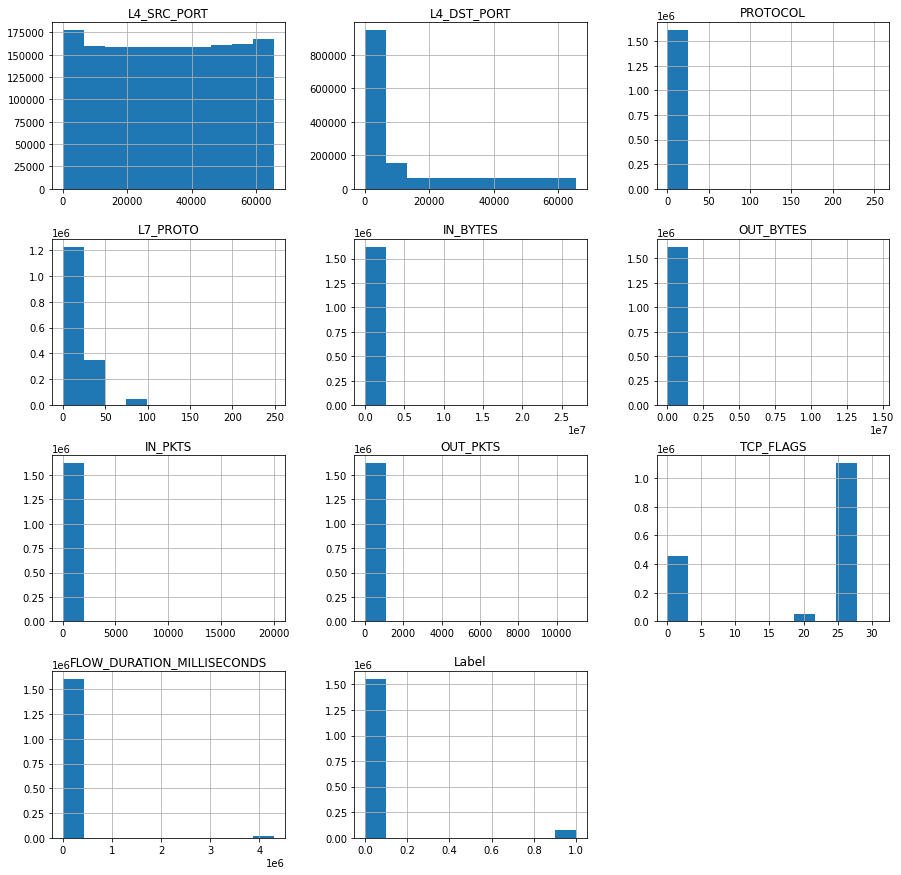

In [5]:
# print histogram for each parameter

figure(figsize=(15, 15), dpi=200)
data.hist(figsize=(15,15))



plt.show()    

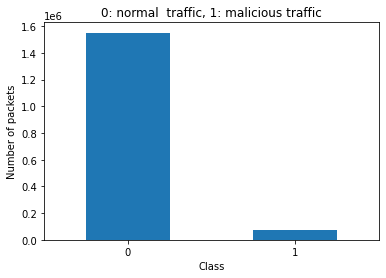

In [6]:
count_classes = pd.value_counts(data['Label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)


plt.xticks(range(len(data['Label'].unique())), data.Label.unique())
plt.title("0: normal  traffic, 1: malicious traffic")
plt.xlabel("Class")
plt.ylabel("Number of packets");

In [7]:
dataPSA=data
dataPSA['IPV4_SRC_ADDR'] = dataPSA.IPV4_SRC_ADDR.apply(str)
dataPSA['L4_SRC_PORT'] = dataPSA.L4_SRC_PORT.apply(str)
dataPSA['IPV4_DST_ADDR'] = dataPSA.IPV4_DST_ADDR.apply(str)
dataPSA['L4_DST_PORT'] = dataPSA.L4_DST_PORT.apply(str)

#dataPSA["id"]=dataPSA.index.tolist()
#dataPSA["id"]=dataPSA.id.apply(str)

dataPSA['IPV4_SRC'] = dataPSA['IPV4_SRC_ADDR'].apply(lambda x: int(x.split('.')[0]))##############
dataPSA['IPV4_DST'] = dataPSA['IPV4_DST_ADDR'].apply(lambda x: int(x.split('.')[0]))##############

dataPSA['IPV4_SRC_ADDR'] = dataPSA['IPV4_SRC_ADDR'] + ':' + dataPSA['L4_SRC_PORT'] # + ':' + dataPSA["id"]
dataPSA['IPV4_DST_ADDR'] = dataPSA['IPV4_DST_ADDR'] + ':' + dataPSA['L4_DST_PORT'] # + ':' + dataPSA["id"]
#dataPSA.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

Label=dataPSA.Label

dataPSA.drop(columns=['Attack','Label'],inplace = True)
#dataPSA.drop(columns=['id'],inplace = True)


cols_to_norm =  list(set(list(dataPSA.iloc[:,:].columns ))  - set(list(['Label','IPV4_DST_ADDR','IPV4_SRC_ADDR','IPV4_SRC','IPV4_DST'])) )
#cols_to_norm= list([ 'L4_SRC_PORT', 'L4_DST_PORT','PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS','TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS' ])
scaler = StandardScaler()
dataPSA[cols_to_norm] = scaler.fit_transform(dataPSA[cols_to_norm])

data=  dataPSA
data['x'] = data[ cols_to_norm ].values.tolist()
data['y']= Label
#data = data.sample(frac=1)

In [8]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,IPV4_SRC,IPV4_DST,x,y
0,149.171.126.0:62073,1.533064,59.166.0.5:56082,2.156942,-0.310688,-0.662235,0.055297,-0.241222,-0.321254,-0.325353,0.491743,-0.114590,149,59,"[-0.3212541349577168, -0.24122205108027828, -0...",0
1,149.171.126.2:32284,-0.018622,59.166.0.5:1526,-0.627424,-0.310688,-0.662235,-0.045403,-0.243001,-0.377537,-0.370978,0.491743,-0.114621,149,59,"[-0.37753746539909167, -0.2430006347449005, -0...",0
2,149.171.126.0:21,-1.699176,59.166.0.1:21971,0.416024,-0.310688,-0.613740,-0.044561,-0.236548,-0.152404,-0.218896,0.491743,-0.112312,149,59,"[-0.1524041436335923, -0.23654756837197627, -0...",0
3,59.166.0.1:23800,-0.460547,149.171.126.0:46893,1.687964,-0.310688,-0.662235,-0.061319,-0.193292,-0.332511,-0.294937,0.657499,-0.114364,59,149,"[-0.3325108010459918, -0.1932915015541769, -0....",0
4,59.166.0.5:63062,1.584581,149.171.126.2:21,-0.704234,-0.310688,-0.613740,-0.045275,-0.230254,-0.084864,-0.127647,0.491743,-0.111589,59,149,"[-0.08486414710394252, -0.23025411848177457, -...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623113,59.166.0.2:1640,-1.614844,149.171.126.8:53,-0.702601,0.567682,-0.662235,-0.066394,-0.242670,-0.422564,-0.370978,-1.580216,-0.114621,59,149,"[-0.42256412975219154, -0.24267000060211816, 0...",0
1623114,59.166.0.2:3610,-1.512228,149.171.126.6:21,-0.704234,-0.310688,-0.613740,-0.041985,-0.229889,-0.039837,-0.127647,0.574621,-0.114621,59,149,"[-0.039837482750842645, -0.22988928080698026, ...",0
1623115,59.166.0.2:4667,-1.457170,149.171.126.6:40725,1.373169,-0.310688,-0.662235,-0.063971,-0.232660,-0.377537,-0.325353,0.657499,-0.114621,59,149,"[-0.37753746539909167, -0.2326597668999495, -0...",0
1623116,59.166.0.2:5641,-1.406435,149.171.126.6:56243,2.165159,-0.310688,-0.662235,-0.061319,-0.193292,-0.332511,-0.294937,0.657499,-0.114621,59,149,"[-0.3325108010459918, -0.1932915015541769, -0....",0


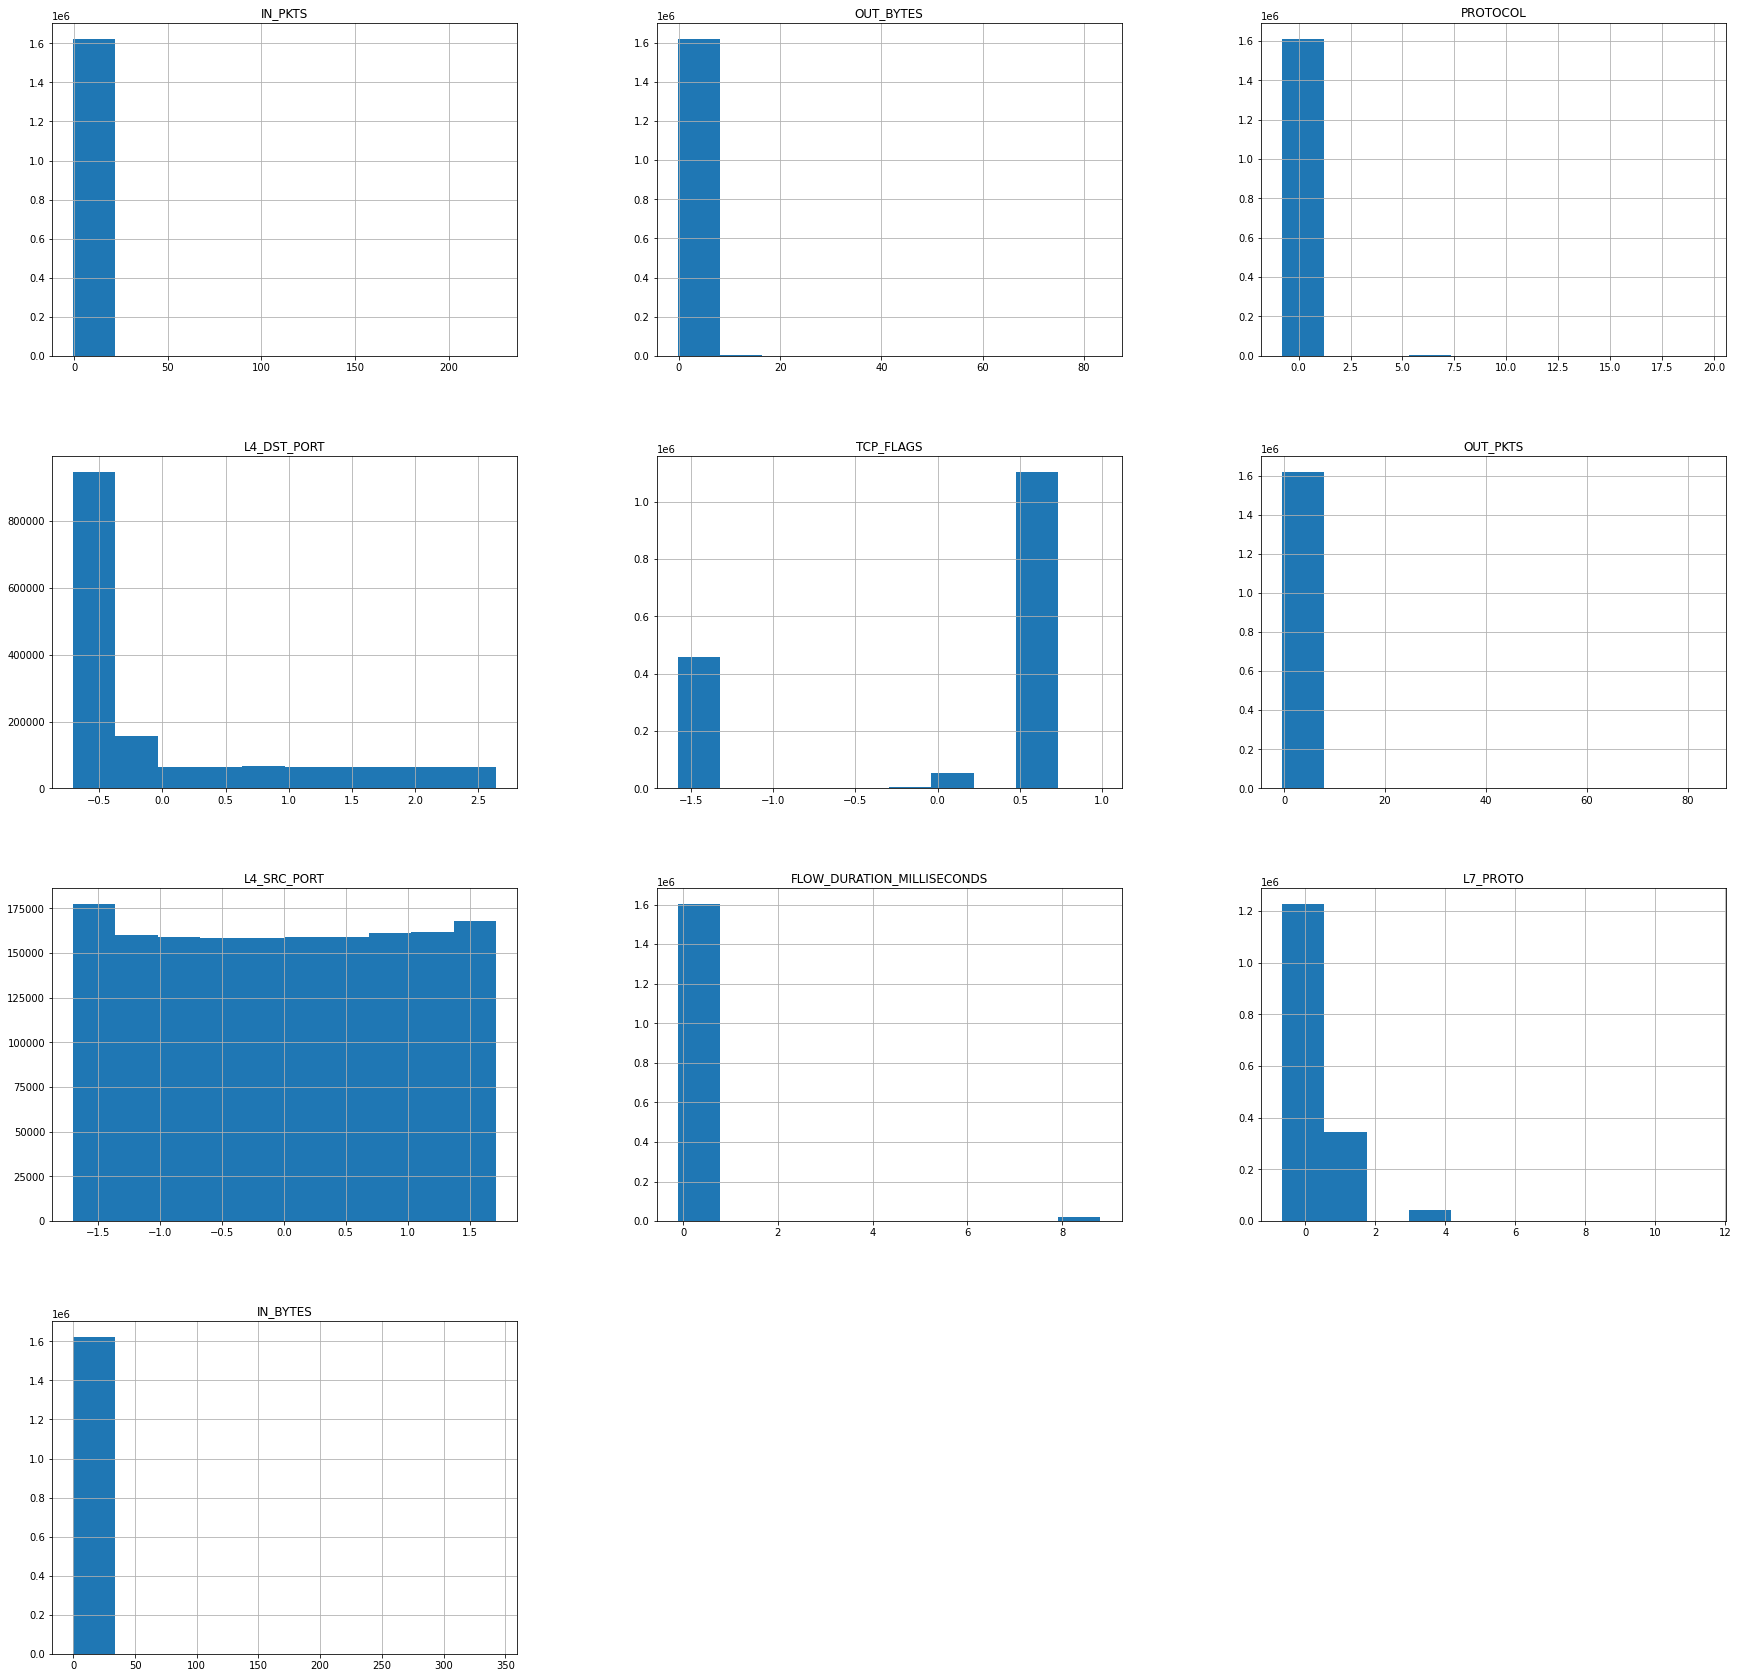

In [9]:
data[cols_to_norm].hist(figsize=(30,30))
plt.show()

In [10]:
import seaborn as sns

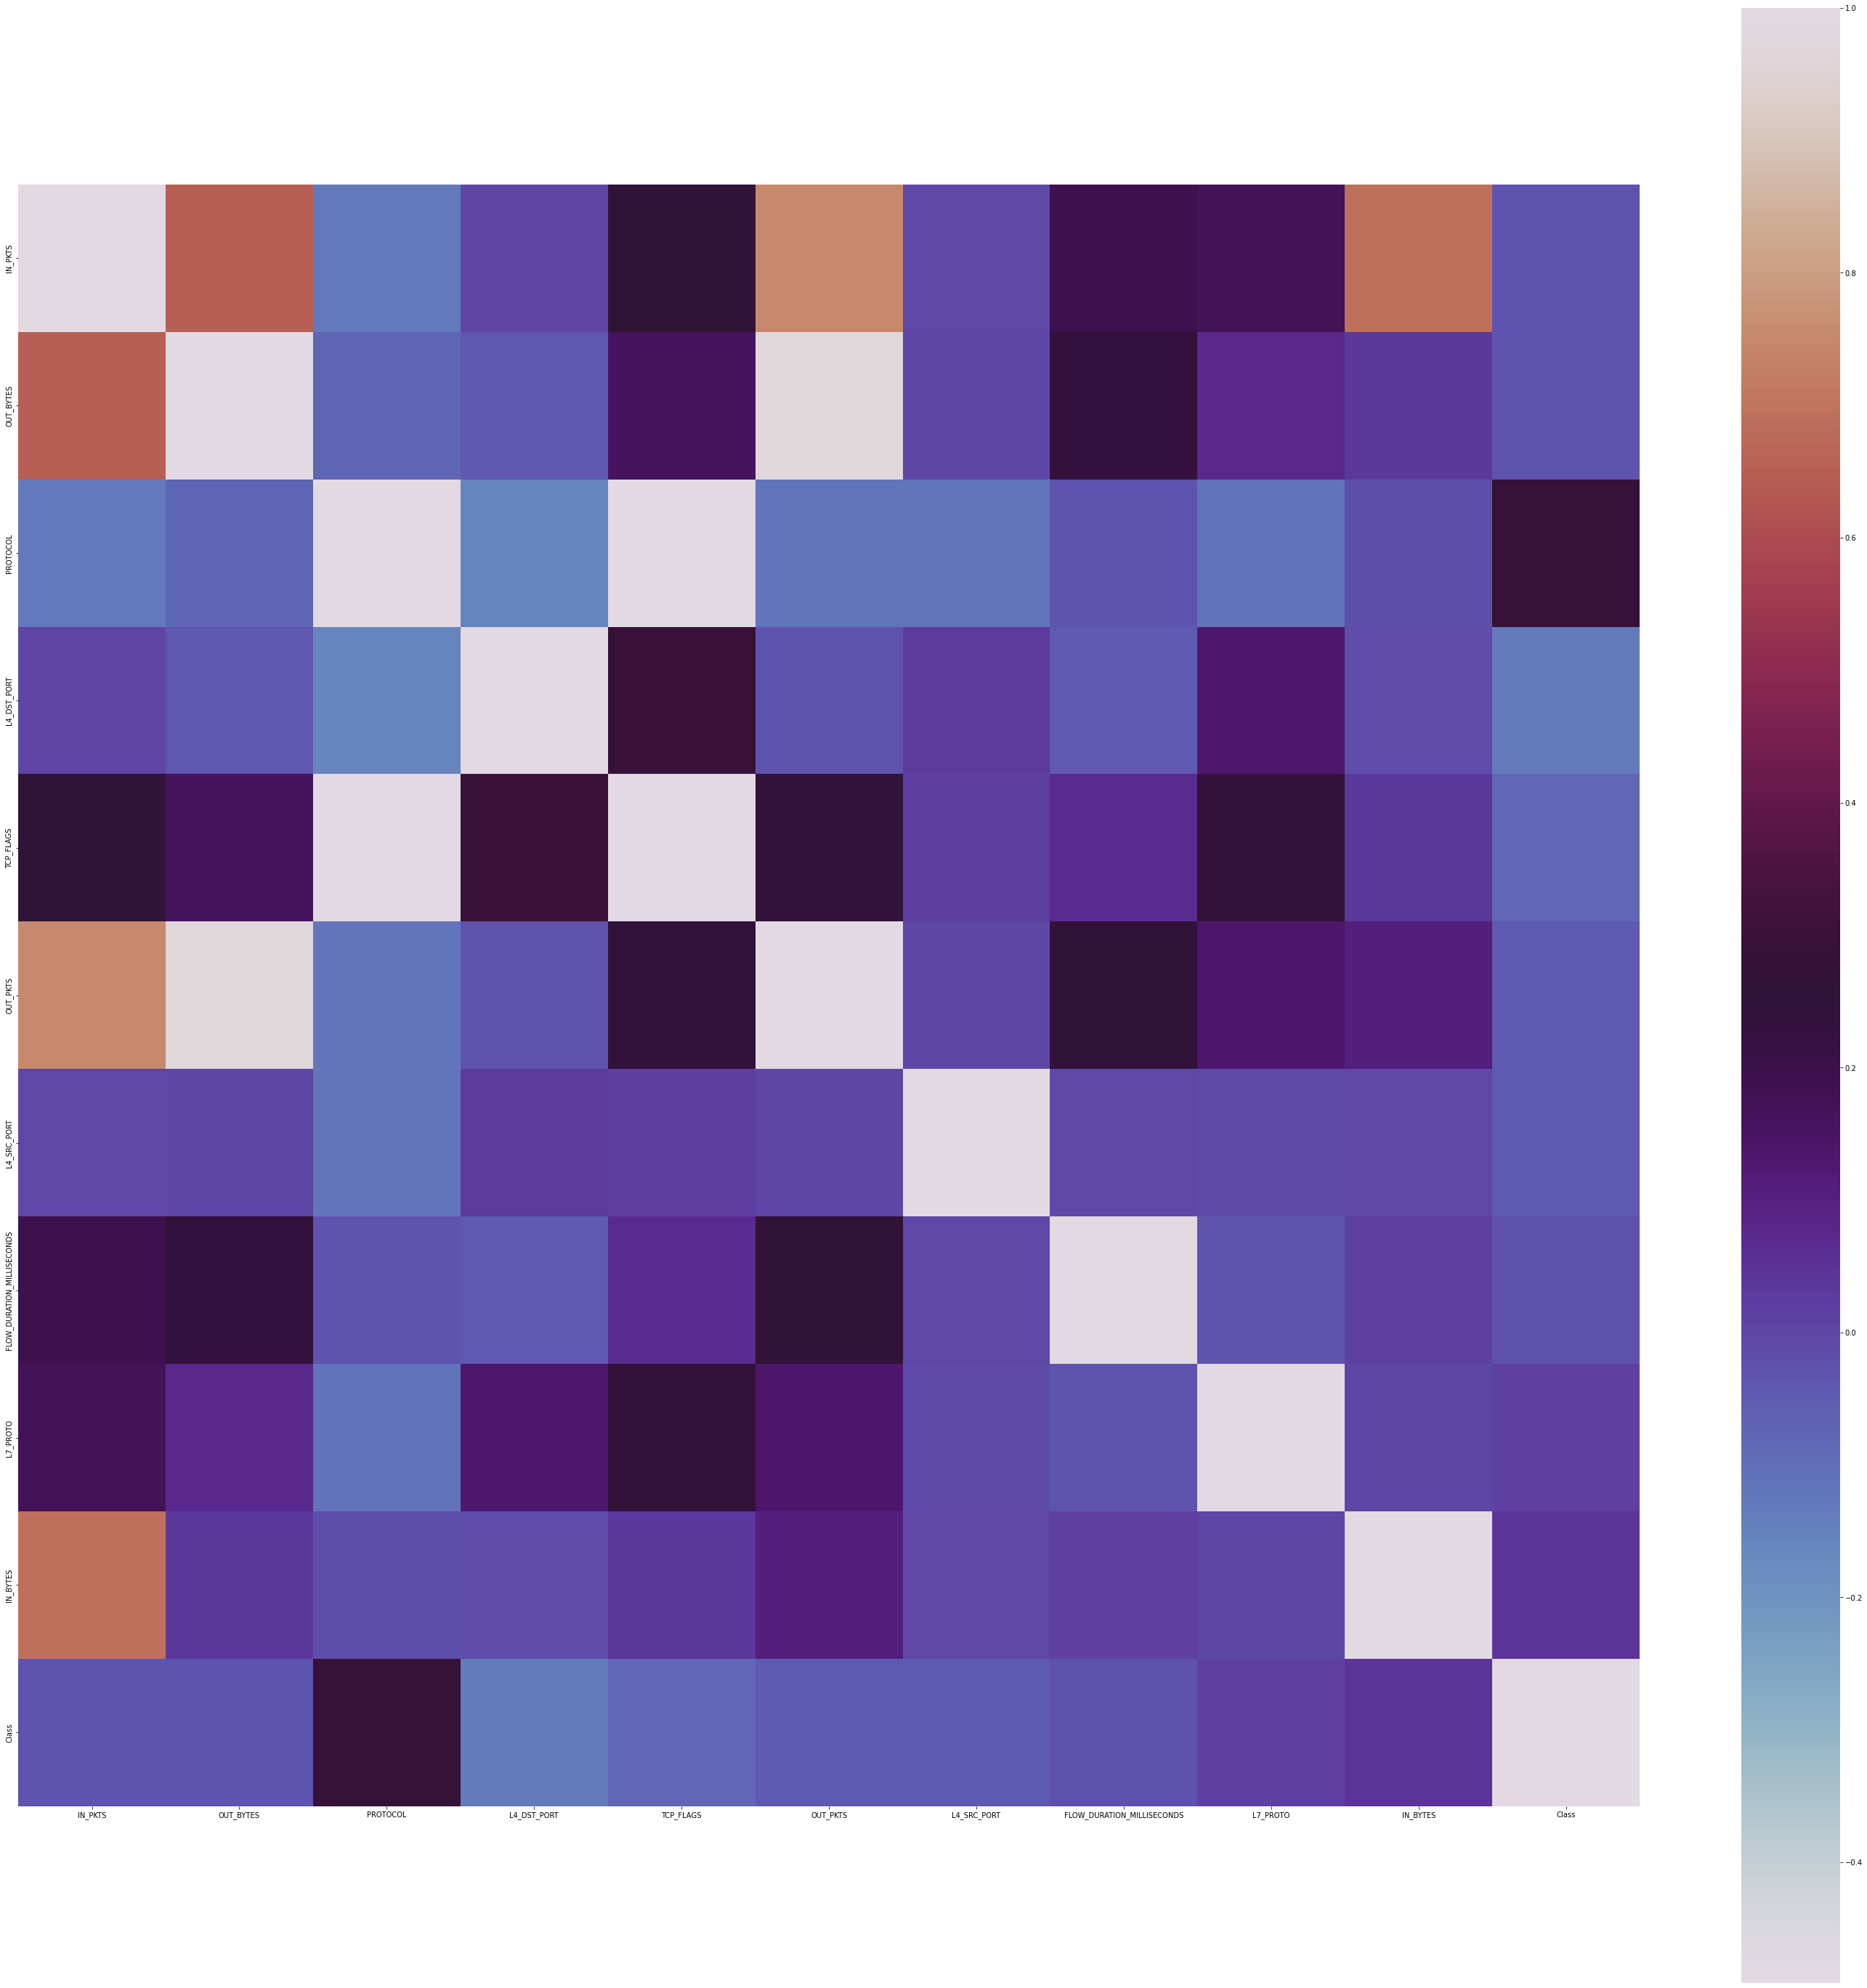

In [11]:
XstdY = data[cols_to_norm].copy()
XstdY['Class'] = data['y']
cormat = XstdY.corr()
fig = plt.figure(figsize=(50,50))

sns.heatmap(cormat, square=True, cmap=plt.cm.twilight)
plt.show()

<AxesSubplot:>

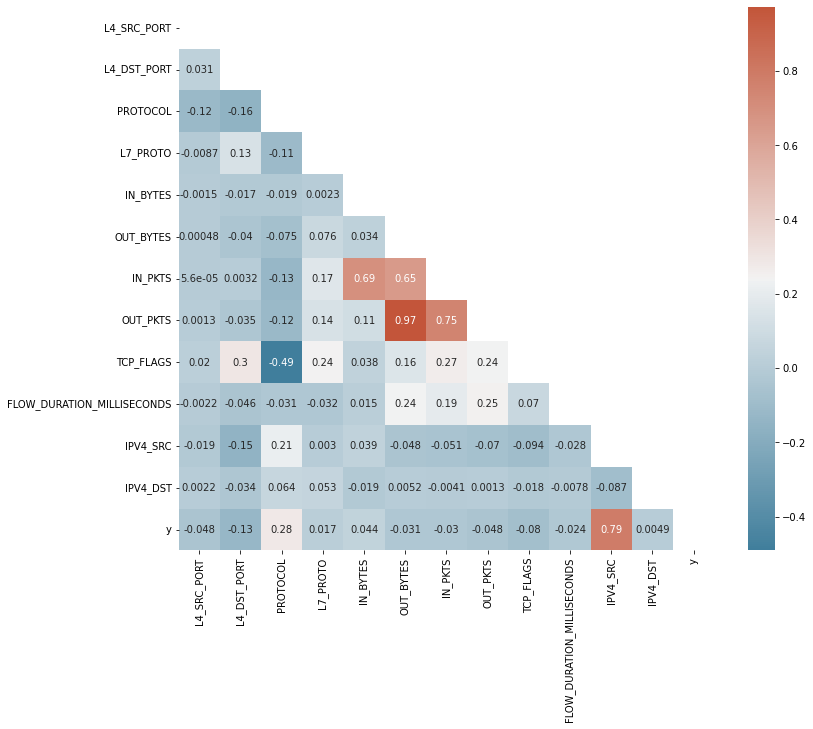

In [12]:

# Correlation between different variables
#
corr = data.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
